# Chapter 4 - Machine Learning-Based Volatility Prediction

Markowitz defined volatility as standard deviation

Volatility is the backbone of finance since is an input to various financial models $\rightarrow$ uncertainty or, the degree at which values of financial assets changes

Return volatility:

$$ \sigma = \sqrt{\frac{1}{n-1}\sum_{n=1}^N (r_n - \mu_r)^2}

where $r$ and $\mu_r$ are return and mean of return and $n$ the number of observations

In [3]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings("ignore")

In [4]:
stocks = "^GSPC"
start= datetime.datetime(2010, 1, 1)
end= datetime.datetime(2021, 8, 1)
s_p500= yf.download(stocks, start=start, end=end, interval="1d")

[*********************100%***********************]  1 of 1 completed


In [ ]:
ret = 100 * (s_p500.pct_change()[1:]['Close'])
realized_vol = ret.rolling(5).std()




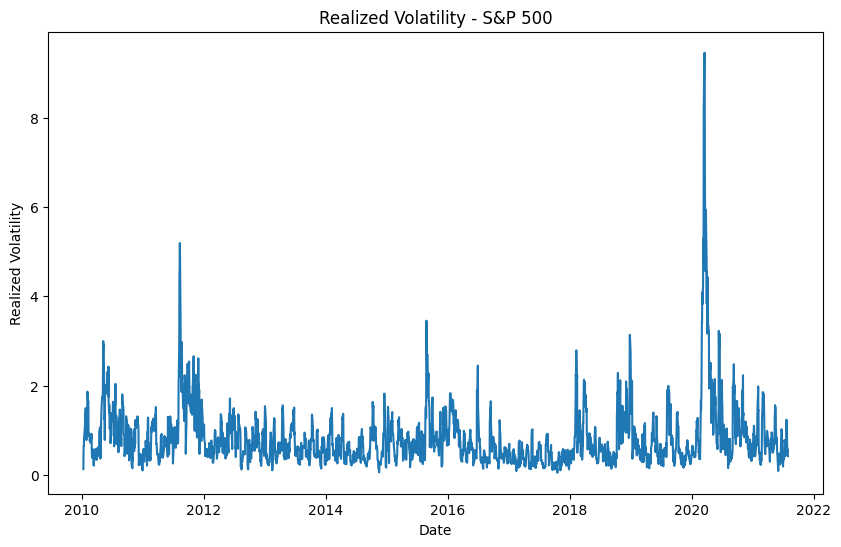

In [10]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol.index, realized_vol)
plt.title("Realized Volatility - S&P 500")
plt.xlabel("Date")
plt.ylabel("Realized Volatility")
plt.show()

We can see a big spike around COVID-19.

In this chapter it will be introduced:

- ARCH

- GARCH

- GJR-GARCH

- EGARCH

## ARCH Model


ARCH Model is a univariate model and is based on historical asset returns:

$$ \sigma_t ^2 = \omega + \sum_{k=1}^p \alpha_k (r_{t-k})^2$$


where the mean model is:
$$ r_t = \sigma_t \epsilon _t

where $\epsilon_t$ is assumed to be a normal distribution.

In this parametric model, we need to satisfy assumptions:

- $\omega > 0$

- $\alpha_k > 0$

Plotting clustering

In [ ]:
retv = ret.values

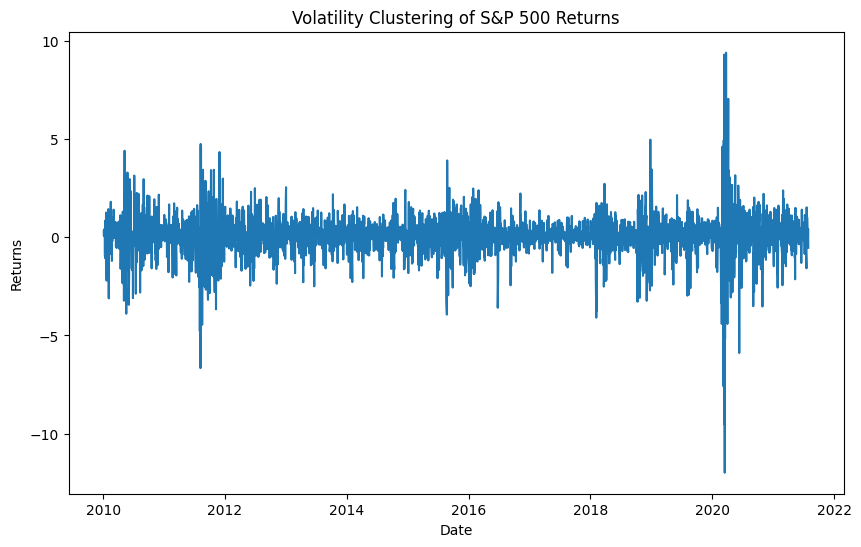

In [37]:
plt.figure(figsize=(10,6))
plt.plot(s_p500.index[1:], ret)
plt.title("Volatility Clustering of S&P 500 Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

Drawbacks of ARCH:

- Equal response to positive and negative shocks

- Strong assumptions such as restrictions on parameters

- Possible misprediction dure to slow adjustements to large movements

In [38]:
n = 252
split_date = ret.iloc[-n:].index

In [ ]:
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 * (3.0 * sgm2 - K) *K)) / (6*K)
omega = (1-alpha) * sgm2
initial_parameters = [alpha, omega]
omega, alpha

(Ticker
 ^GSPC    0.634156
 dtype: float64,
 Ticker
 ^GSPC    0.466731
 dtype: float64)

In [45]:
@jit(nopython=True,parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = abs (initial_parameters[0])
    alpha = abs (initial_parameters[1])
    T = len(retv)
    sigma2 = np.zeros(T)
    logsliks= 0
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t-1])**2
    logsliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logsliks

In [46]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function abs>) found for signature:
 
 >>> abs(array(float64, 1d, C))
 
There are 6 candidate implementations:
      - Of which 2 did not match due to:
      Type Restricted Function in function 'abs': File: unknown: Line unknown.
        With argument(s): '(array(float64, 1d, C))':
       No match for registered cases:
        * (int8,) -> int8
        * (int16,) -> int16
        * (int32,) -> int32
        * (int64,) -> int64
        * (uint8,) -> uint8
        * (uint16,) -> uint16
        * (uint32,) -> uint32
        * (uint64,) -> uint64
        * (float32,) -> float32
        * (float64,) -> float64
        * (complex64,) -> float32
        * (complex128,) -> float64
      - Of which 4 did not match due to:
      Overload of function 'abs': File: <numerous>: Line N/A.
        With argument(s): '(array(float64, 1d, C))':
       No match.

During: resolving callee type: Function(<built-in function abs>)
During: typing of call at /var/folders/rs/wmb9tlw54_57w8bqd4qxp_zh0000gn/T/ipykernel_3234/1029469875.py (3)


File "../../../../../../var/folders/rs/wmb9tlw54_57w8bqd4qxp_zh0000gn/T/ipykernel_3234/1029469875.py", line 3:
<source missing, REPL/exec in use?>
